In [1]:
import math

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import linear_model

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Read data

In [2]:
train = pd.read_csv("../data/raw/mower_market_snapshot.csv", sep=";")
test = pd.read_csv("../data/raw/submission_set.csv", sep=";")

# Show first rows

In [3]:
print("train size:", train.shape, "| test size:", test.shape)

train size: (1399, 11) | test size: (600, 9)


In [4]:
train.head(), test.head()

(    capacity  failure_rate     id      margin       price           prod_cost  \
 0  10.492623      0.042528  18377  633.766584  828.802103  195.03551928211797   
 1  20.273730      0.037896  19363  731.576817  882.894916  151.31809934886763   
 2  20.190457      0.039111  19641  741.218202  919.355522  178.13731921134948   
 3  27.220131      0.041303  18728  654.255635  817.085097  162.82946157588628   
 4  16.370911      0.037938  18722  703.094527  844.581465  141.48693796090603   
 
   product_type quality warranty  market_share  attractiveness  
 0  auto-portee     Low     3ans      0.006360        0.650648  
 1  auto-portee     Low   3 ans.      0.006840        0.699792  
 2  auto-portee     Low    3_ans      0.006179        0.632129  
 3  auto-portee     Low   3 anss      0.007925        0.810730  
 4  auto-portee  Medium    3ans.      0.007406        0.757614  ,
     capacity  failure_rate     id      margin       price   prod_cost  \
 0  21.313064      0.037928  20049  613.0

# Data Cleaning

### Warranty

In [5]:
import re

train["warranty"] = train["warranty"].apply(lambda x: re.sub("[^0-9]", "", x))
train["warranty"] = train["warranty"].astype(int)

test["warranty"] = test["warranty"].apply(lambda x: re.sub("[^0-9]", "", x))
test["warranty"] = test["warranty"].astype(int)

### Prod_cost should be a float

In [6]:
def clean_prod_cost(row):
    try:
        return float(row)
    except ValueError as _:
        return -1.0

train["prod_cost"] = train["prod_cost"].apply(lambda x: clean_prod_cost(x))

test["prod_cost"] = test["prod_cost"].apply(lambda x: clean_prod_cost(x))

##### We need to take only row which contains a positiv prod_cost

In [7]:
train = train[train["prod_cost"] > 0]

## Feature engineering

### Build profit, & quality price features

In [8]:
def build_profit(row):
    return (row["price"] - row["prod_cost"]) / row["price"]


def build_quality_price(row):
    if row["price"] >= medium and row["quality"] == "Hight":
        return "Hight"
    if row["price"] >= medium and row["quality"] == "Medium":
        return "Low"
    if row["price"] >= medium and row["quality"] == "Low":
        return "Low"
    
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Hight":
        return "Hight"
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Medium":
        return "Medium"
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Low":
        return "Low"

    if row["price"] < low and row["quality"] == "Hight":
        return "Hight"
    if row["price"] < low and row["quality"] == "Medium":
        return "Hight"
    if row["price"] < low and row["quality"] == "Low":
        return "Medium"  

    
low = train.price.describe()["50%"]
medium = train.price.describe()["75%"]
good = train.price.describe()["max"]
train["profit"] = train.apply(lambda x: build_profit(x), axis=1)
train["quality_price"] = train.apply(lambda x: build_quality_price(x), axis=1)

test["profit"] = test.apply(lambda x: build_profit(x), axis=1)
test["quality_price"] = test.apply(lambda x: build_quality_price(x), axis=1)

### Here I use a simple OneHotEncoder for categorical variables

In [9]:
train = pd.concat([train, pd.get_dummies(train["product_type"], prefix="prod_type", drop_first=True)], axis=1)
train = train.drop("product_type", axis=1)
train = pd.concat([train, pd.get_dummies(train["quality"], prefix="quality", drop_first=True)], axis=1)
train = train.drop("quality", axis=1)
train = pd.concat([train, pd.get_dummies(train["quality_price"], prefix="quality_price", drop_first=True)], axis=1)
train = train.drop("quality_price", axis=1)

test = pd.concat([test, pd.get_dummies(test["product_type"], prefix="prod_type", drop_first=True)], axis=1)
test = test.drop("product_type", axis=1)
test = pd.concat([test, pd.get_dummies(test["quality"], prefix="quality", drop_first=True)], axis=1)
test = test.drop("quality", axis=1)
test = pd.concat([test, pd.get_dummies(test["quality_price"], prefix="quality_price", drop_first=True)], axis=1)
test = test.drop("quality_price", axis=1)

### Remove id (useless), & "market_share", "attractiveness" from the train set of course

In [10]:
X = train.drop(["market_share", "attractiveness", "id"], axis=1)
y = train["attractiveness"]

test = test.drop("id", axis=1)

### Data Cleaning & fast feature engineering is done

In [11]:
train.describe()

,capacity,failure_rate,id,margin,price,prod_cost,warranty,market_share,attractiveness,profit,prod_type_electrique,prod_type_essence,quality_Low,quality_Medium,quality_price_Low,quality_price_Medium
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,47.622208,0.166274,18957.304511,186.133891,244.018130,57.884239,1.498496,0.002141,0.636438,0.800636,0.296992,0.602256,0.696241,0.209023,0.374436,0.442105
std,19.933097,0.073468,404.971241,190.494666,246.668906,60.346610,0.672191,0.001779,0.124263,0.070595,0.457105,0.489616,0.460053,0.406763,0.484159,0.496824
min,0.013884,0.028906,18259.000000,52.943989,62.855737,7.095443,1.000000,0.000564,0.297384,0.619800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.840060,0.095719,18606.250000,62.257830,73.259116,10.779788,1.000000,0.001135,0.548766,0.728305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.370335,0.199655,18956.000000,66.411687,77.963302,12.255099,1.000000,0.001405,0.641078,0.836865,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,61.868304,0.227943,19307.750000,265.447661,380.436817,114.211909,2.000000,0.002448,0.727568,0.853517,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,104.614865,0.302465,19657.000000,790.012898,964.973926,210.984941,3.000000,0.009314,0.952877,0.897748,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check device which have a prod_cost > price

In [12]:
print("There are", len(train[train["prod_cost"] >= train["price"]]), "device selling at a loss")
print("There are", len(test[test["prod_cost"] >= test["price"]]), "device selling at a loss")
print("Looks good")

There are 0 device selling at a loss
There are 0 device selling at a loss
Looks good


# Plot the distribution

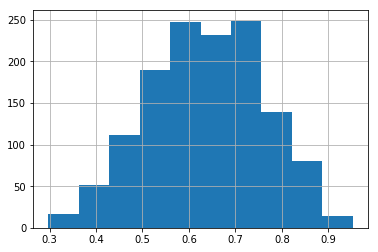

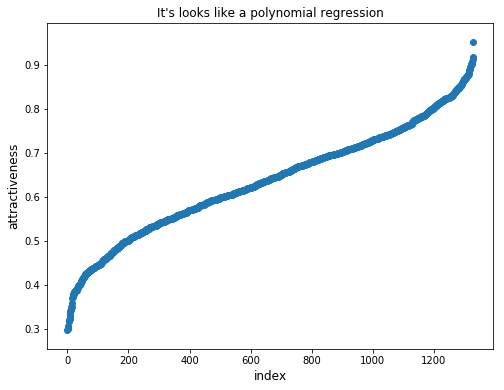

In [13]:
train.attractiveness.hist()
plt.figure(figsize=(8, 6))
plt.scatter(range(train.shape[0]), np.sort(train.attractiveness.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

# Show correlation

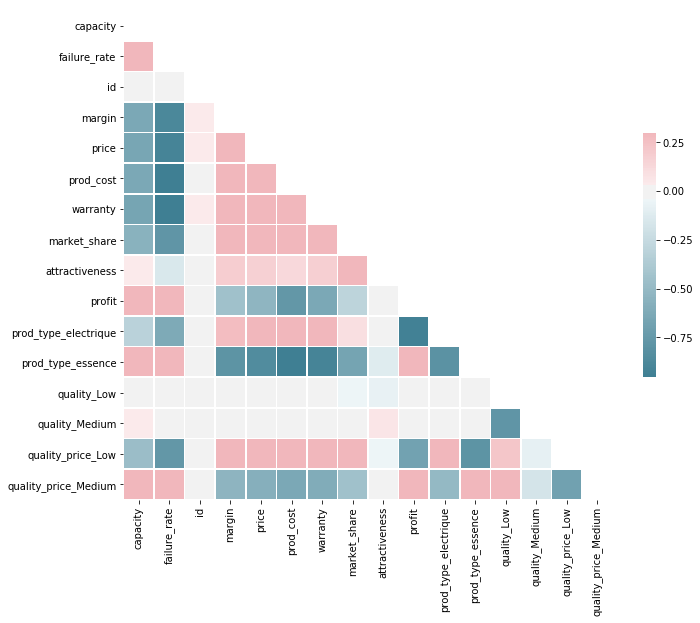

In [14]:
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Check Multicolinearity (VIF)

In [15]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print("if the VIF value is > 5, there is Multicolinearity")
vif.round(3)

if the VIF value is > 5, there is Multicolinearity


,VIF Factor,features
0,1.774000,capacity
1,15.579000,failure_rate
2,inf,margin
3,inf,price
4,inf,prod_cost
5,2072.903000,warranty
6,37.986000,profit
7,201.977000,prod_type_electrique
8,1754.609000,prod_type_essence
9,8.582000,quality_Low


# As baseline I'll use a linear regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [17]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

### Metric

In [18]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)

    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

### Show results over multiple metrics

In [19]:
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficients":np.transpose(reg.coef_)}).sort_values(by="Coefficients")
print('Coefficients: \n', coefficients)
print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))
print("Mean is", y.mean())
print("Here we are good compare to the mean")

Coefficients: 
     Coefficients               Feature
7      -0.336338  prod_type_electrique
6      -0.316701                profit
8      -0.302219     prod_type_essence
11     -0.159145     quality_price_Low
1      -0.105006          failure_rate
12     -0.039867  quality_price_Medium
3      -0.001920                 price
4      -0.001613             prod_cost
2      -0.000308                margin
0       0.002054              capacity
9       0.040648           quality_Low
10      0.047463        quality_Medium
5       0.940777              warranty
RMSLE: 0.063
RMSE: 0.102
Variance score: 0.303
Mean is 0.6364382104685304
Here we are good compare to the mean


### Show features importance

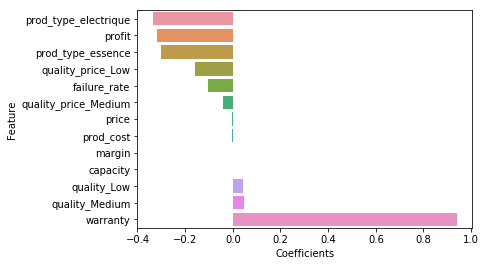

In [20]:
sns.barplot(y="Feature", x="Coefficients", data=coefficients)

### Plot the predict against real

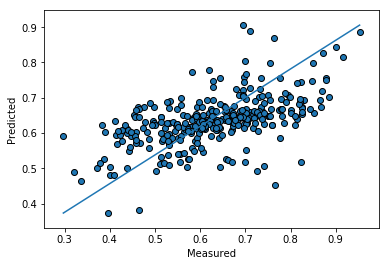

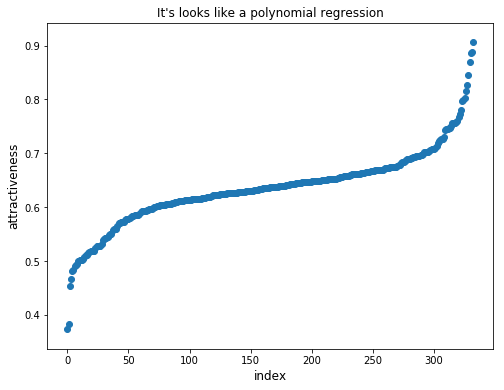

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022665B80F98>]], dtype=object)

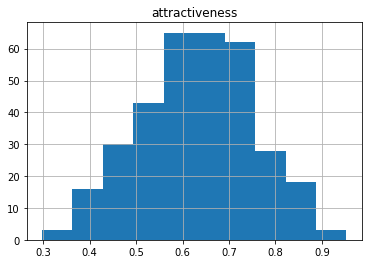

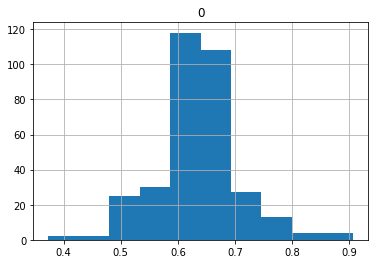

In [21]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

### Apply polynomial featuring

In [22]:
p = PolynomialFeatures(degree=2).fit(X)
cols = p.get_feature_names(X.columns)
X = train.drop(["market_share", "attractiveness", "id"], axis=1)
y = train["attractiveness"]
poly_reg = PolynomialFeatures(degree=2)
X = poly_reg.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
x_train = X_train
x_test = X_test
y_test = np.array(y_test)
y_train = np.array(y_train)

## Run model with the new features

RMSLE: 0.042
RMSE: 0.068
Variance score: 0.688


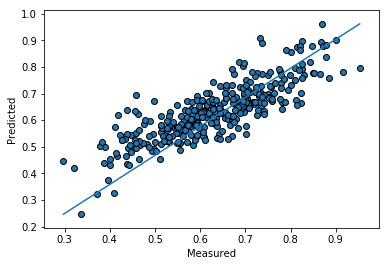

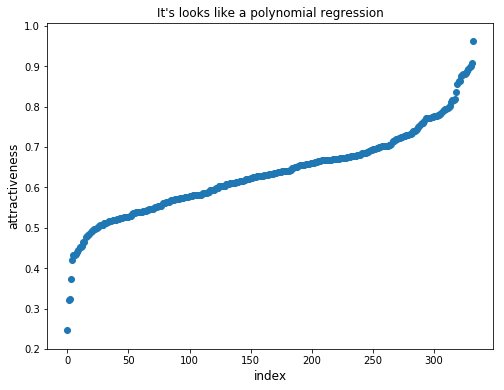

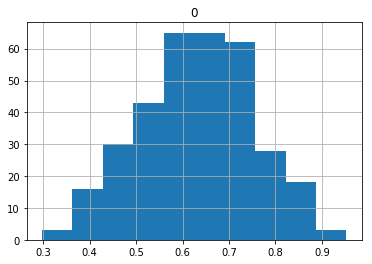

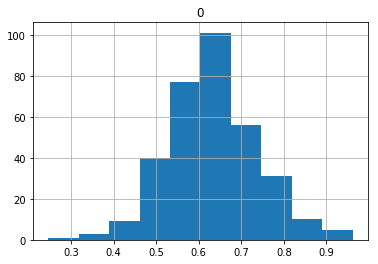

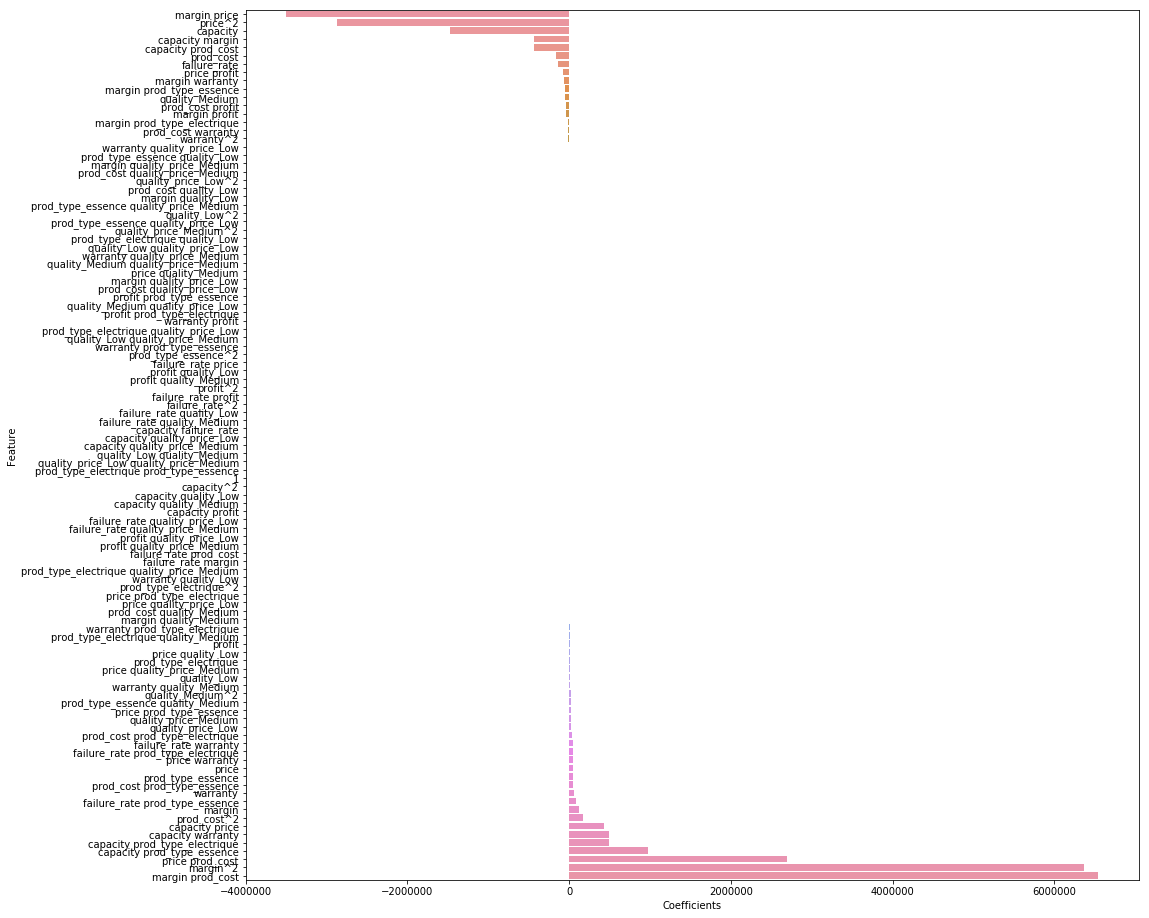

In [23]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

f, ax = plt.subplots(figsize=(16, 16))
coefficients = pd.DataFrame({"Feature": cols, "Coefficients":np.transpose(reg.coef_)}).sort_values(by="Coefficients")
sns.barplot(y="Feature", x="Coefficients", data=coefficients)
plt.show()

# Apply some features selection
### backward for example

In [24]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break

    return included

x = pd.DataFrame(X, columns=cols)
y = list(y)

useful_cols = stepwise_selection(x, y)

Add  1                              with p-value 0.0
Add  prod_type_essence quality_price_Low with p-value 8.66169e-21
Add  margin^2                       with p-value 1.6919e-12
Add  capacity^2                     with p-value 9.72526e-25
Add  prod_type_electrique quality_price_Medium with p-value 4.84489e-11
Add  quality_Medium quality_price_Medium with p-value 6.6111e-10
Add  capacity profit                with p-value 1.25756e-06
Add  failure_rate margin            with p-value 1.06258e-06
Add  price prod_type_essence        with p-value 1.12342e-33
Add  price                          with p-value 3.01681e-72
Drop quality_Medium quality_price_Medium with p-value 0.563099
Add  price prod_type_electrique     with p-value 3.16887e-59
Add  price warranty                 with p-value 8.26984e-134
Add  profit quality_Low             with p-value 6.54894e-65
Drop prod_type_essence quality_price_Low with p-value 0.575914
Add  margin price                   with p-value 2.92263e-11
Drop fai

## Now we'll use only the most relevant features in our model
### Yes I know there are only the linear relation, but this project it's enough

Score on test set: 0.0523877846465
RMSLE: 0.041
RMSE: 0.066
Variance score: 0.705


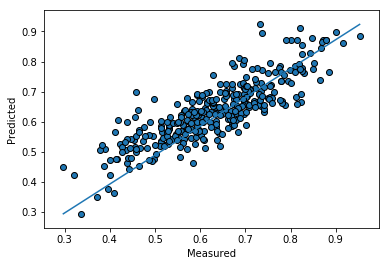

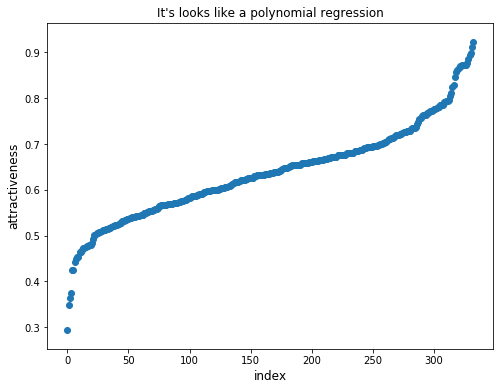

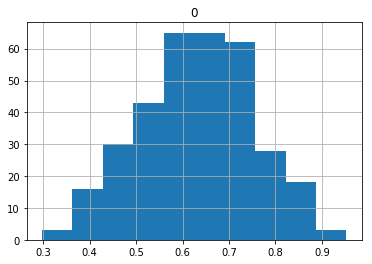

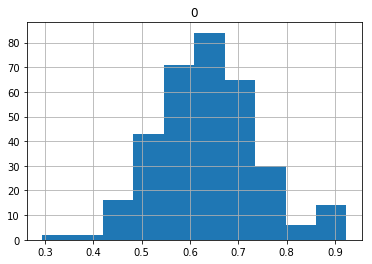

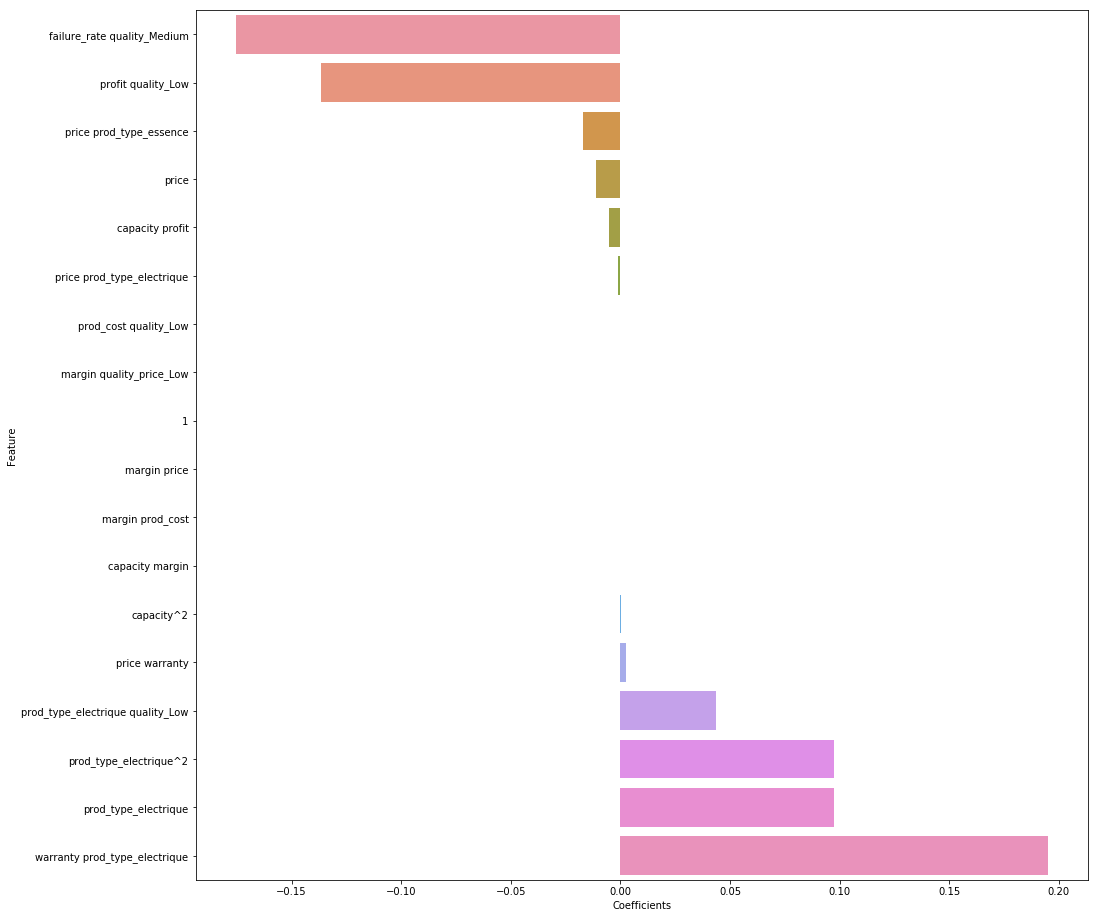

In [25]:
regression = True
x = x[useful_cols]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
x_train = X_train
x_test = X_test
y_test = np.array(y_test)
y_train = np.array(y_train)

# Build model with good params
model = linear_model.LinearRegression()

# Fit the model
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Scoring
if regression:
    print('Score on test set:', mean_absolute_error(y_test, y_pred))
else:
    print('Score on test set:', accuracy_score(y_test, y_pred))

    
print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

f, ax = plt.subplots(figsize=(16, 16))
coefficients = pd.DataFrame({"Feature": x.columns, "Coefficients":np.transpose(model.coef_)}).sort_values(by="Coefficients")
sns.barplot(y="Feature", x="Coefficients", data=coefficients)
plt.show()

# Predict test set

In [26]:
test = poly_reg.fit_transform(test)
test = pd.DataFrame(test, columns=cols)
test = test[useful_cols]
y_pred = model.predict(test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["attractiveness"]

# Submission

In [27]:
submission = pd.read_csv("../data/raw/submission_set.csv", sep=";")
submission = pd.concat([submission, y_pred], axis=1)
submission.to_csv("submission.csv", index=False, sep=";")